In [1]:
#imports
import dask
import dask.dataframe as dd
from dask.distributed import Client, progress
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
import pandas as pd
import numpy as np
import dask_ml
#prefs
pd.set_option('max_columns', None)


In [2]:
#close existing dask connection if it exists and open a new one
try:
    if client is not None:
        client.close()
        print("closed existing connection, ",client)       
except Exception as e:
    print(e)
    

name 'client' is not defined


In [3]:
#get new connection
client = Client(n_workers=2, threads_per_worker=2, memory_limit='8GB')
display(client)

Client Scheduler: tcp://127.0.0.1:38029 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 12.26 GiB


In [4]:
# train on FTP-BruteForce data
data1 = dd.read_csv("ids-data/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv",dtype={'Active Mean': 'float64',
       'Active Std': 'float64', 'Label': 'str'})

data2 = dd.read_csv("ids-data/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv",dtype={'Active Mean': 'float64',
       'Active Std': 'float64', 'Label': 'str'})

data = data1.append(data2)


In [5]:
%%time

def time_cleaner(t):
    date, time = t.split()
    hour, minute, second = time.split(':')
    if int(hour) < 8:
        hour = int(hour) + 12
    
    return f'{date} {hour}:{minute}:{second}'

data['Timestamp'] = data['Timestamp'].apply(lambda x: time_cleaner(x), meta=('Timestamp', 'str'))
data['Timestamp'] = dd.to_datetime(data.Timestamp, format='%d/%m/%Y %H:%M:%S').astype(np.int64)
data['Timestamp'] = data['Timestamp'].apply(lambda x: np.int64(x / 1000000000), meta=('Timestamp', 'int64'))

# There is some data that need to be dropped because they are corrupted. Easiest way to tell is if the
# timestamp is completely off. We'll say anything before January 1 2018 needs to be dropped
import datetime
timestamp_cutoff = np.int64(datetime.datetime(2018, 1, 1).timestamp())
print(len(data))
data = data[data.Timestamp > timestamp_cutoff]
print(len(data))

data['Timestamp'] = data['Timestamp'].apply(lambda x: np.int64(x / 600), meta=('Timestamp', 'int64'))

max_val = np.finfo(np.float32).max
data['Flow Byts/s'] = data['Flow Byts/s'].apply(lambda x: x if x < max_val else max_val, meta=('Flow Byts/s', 'float32'))
data['Flow Pkts/s'] = data['Flow Pkts/s'].apply(lambda x: x if x < max_val else max_val, meta=('Flow Pkts/s', 'float32'))

data['Label'] = data['Label'].apply(lambda x: 0 if x == 'Benign' else 1, meta=('Label', 'int32'))

clean_data = data.persist()
len(clean_data)


2097150
2097145
CPU times: user 4.32 s, sys: 1.19 s, total: 5.51 s
Wall time: 1min 7s


2097145

In [6]:
# Possible features
# Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label

#agg_data = clean_data.groupby(['Timestamp', 'Dst Port', 'Protocol']).agg(
agg_data = clean_data.groupby(['Timestamp']).agg(    
    {
        'Flow Duration': ['mean', 'count'],
        'Tot Fwd Pkts': ['sum'],
        'Tot Bwd Pkts': ['sum'],
        'TotLen Fwd Pkts' : ['sum'],
        'TotLen Bwd Pkts' : ['sum'],
        'Fwd Pkt Len Max' : ['mean'],
        'Fwd Pkt Len Min' : ['mean'],
        'Fwd Pkt Len Mean' : ['mean'],
        'Fwd PSH Flags' : ['sum'],
        'Bwd PSH Flags' : ['sum'],
        'Fwd URG Flags' : ['sum'],
        'Bwd URG Flags' : ['sum'],
        'FIN Flag Cnt' : ['sum'],
        'SYN Flag Cnt' : ['sum'],
        'RST Flag Cnt' : ['sum'],
        'PSH Flag Cnt' : ['sum'],
        'ACK Flag Cnt' : ['sum'],
        'URG Flag Cnt' : ['sum'],
        'CWE Flag Count' : ['sum'],
        'ECE Flag Cnt' : ['sum'],
        'Pkt Size Avg' : ['mean'],
        'Fwd IAT Mean' : ['mean'],
        'Bwd IAT Mean' : ['mean'],
        'Idle Min' : ['mean'],
        'Label': ['sum']
    }
)

agg_data.head()



Flow Duration        Tot Fwd Pkts Tot Bwd Pkts TotLen Fwd Pkts  \
                   mean  count          sum          sum             sum   
Timestamp                                                                  
2530994    1.954830e+07   3698        21743        27287         1387755   
2530995    1.481148e+07  24791       131047       163571         8949505   
2530996    1.286984e+07  20347        93250       108736         6300350   
2530997    1.246500e+07  18457       211461       482461         7257236   
2530998    1.210937e+07  13269        82264       105800         5507201   

          TotLen Bwd Pkts Fwd Pkt Len Max Fwd Pkt Len Min Fwd Pkt Len Mean  \
                      sum            mean            mean             mean   
Timestamp                                                                    
2530994          20705189      171.688480       22.797999        52.149311   
2530995         127290417      175.255899       14.128313        48.737690   
2530996          74403076      167.302059       10.424633        44.485686   
2530997         618890987      188.154142       13.212115        49.857525   
2530998          91012725      220.767805        6.883488        53.234428   

          Fwd PSH Flags Bwd PSH Flags Fwd URG Flags Bwd URG Flags  \
                    sum           sum           sum           sum   
Timestamp                                                           
2530994              77             0             0             0   
2530995            1160             0             0             0   
2530996             942             0             0             0   
2530997             528             0             0             0   
2530998             327             0             0             0   

          FIN Flag Cnt SYN Flag Cnt RST Flag Cnt PSH Flag Cnt ACK Flag Cnt  \
                   sum          sum          sum          sum          sum   
Timestamp                                                                    
2530994              8           77           53         1185          540   
2530995            114         1160         1079         9362         6988   
2530996            101          942          994         8307         6498   
2530997             85          528          989         7629         4902   
2530998             48          327         1328         6822         4040   

          URG Flag Cnt CWE Flag Count ECE Flag Cnt Pkt Size Avg  Fwd IAT Mean  \
                   sum            sum          sum         mean          mean   
Timestamp                                                                       
2530994            179              0           53   130.208615  2.046900e+06   
2530995           2222              0         1079   110.000111  3.555996e+06   
2530996           1116              0          994    86.351377  3.465030e+06   
2530997            828              0          989   100.414325  3.601958e+06   
2530998            399              0         1328    88.635325  4.403650e+06   

           Bwd IAT Mean      Idle Min Label  
                   mean          mean   sum  
Timestamp                                    
2530994    1.195182e+06  5.323583e+06     0  
2530995    7.325235e+05  3.309103e+06     0  
2530996    6.663775e+05  2.890157e+06     0  
2530997    6.731745e+05  2.613556e+06     0  
2530998    6.324033e+05  3.106194e+06     0

In [12]:
len(agg_data[agg_data['Label']['sum'] > 0])
len(agg_data)


65900

In [7]:
agg_labels = agg_data['Label']['sum']
agg_train = agg_data.drop('Label', axis=1)

agg_train = agg_train.reset_index()
#agg_train = agg_train.drop('Timestamp', axis=1)
#agg_train = agg_train.drop('Dst Port', axis=1)
#agg_train = agg_train.drop('Protocol', axis=1)
agg_train.head()



/home/mwdehn/.local/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Timestamp Flow Duration        Tot Fwd Pkts Tot Bwd Pkts TotLen Fwd Pkts  \
                     mean  count          sum          sum             sum   
0   2530994  1.954830e+07   3698        21743        27287         1387755   
1   2530995  1.481148e+07  24791       131047       163571         8949505   
2   2530996  1.286984e+07  20347        93250       108736         6300350   
3   2530997  1.246500e+07  18457       211461       482461         7257236   
4   2530998  1.210937e+07  13269        82264       105800         5507201   

  TotLen Bwd Pkts Fwd Pkt Len Max Fwd Pkt Len Min Fwd Pkt Len Mean  \
              sum            mean            mean             mean   
0        20705189      171.688480       22.797999        52.149311   
1       127290417      175.255899       14.128313        48.737690   
2        74403076      167.302059       10.424633        44.485686   
3       618890987      188.154142       13.212115        49.857525   
4        91012725      220.767805        6.883488        53.234428   

  Fwd PSH Flags Bwd PSH Flags Fwd URG Flags Bwd URG Flags FIN Flag Cnt  \
            sum           sum           sum           sum          sum   
0            77             0             0             0            8   
1          1160             0             0             0          114   
2           942             0             0             0          101   
3           528             0             0             0           85   
4           327             0             0             0           48   

  SYN Flag Cnt RST Flag Cnt PSH Flag Cnt ACK Flag Cnt URG Flag Cnt  \
           sum          sum          sum          sum          sum   
0           77           53         1185          540          179   
1         1160         1079         9362         6988         2222   
2          942          994         8307         6498         1116   
3          528          989         7629         4902          828   
4          327         1328         6822         4040          399   

  CWE Flag Count ECE Flag Cnt Pkt Size Avg  Fwd IAT Mean  Bwd IAT Mean  \
             sum          sum         mean          mean          mean   
0              0           53   130.208615  2.046900e+06  1.195182e+06   
1              0         1079   110.000111  3.555996e+06  7.325235e+05   
2              0          994    86.351377  3.465030e+06  6.663775e+05   
3              0          989   100.414325  3.601958e+06  6.731745e+05   
4              0         1328    88.635325  4.403650e+06  6.324033e+05   

       Idle Min  
           mean  
0  5.323583e+06  
1  3.309103e+06  
2  2.890157e+06  
3  2.613556e+06  
4  3.106194e+06

In [8]:
%%time

# Fit and predict based on the FTP-BruteForce attacks
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0)

clf.fit(agg_train)#, y_train)
y_predict = clf.predict(agg_train)

CPU times: user 453 ms, sys: 65.3 ms, total: 519 ms
Wall time: 1.38 s


precision = 0.8275862068965517; recall = 0.7741935483870968; accuracy = 0.8947368421052632


29

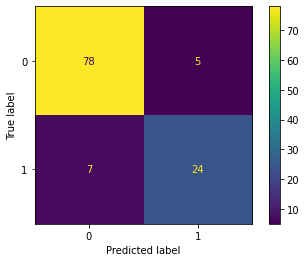

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

predicted = y_predict
actual = [1 if y == 0 else -1 for y in agg_labels]

precision = precision_score(actual, predicted, pos_label=-1)
recall = recall_score(actual, predicted, pos_label=-1)
accuracy = accuracy_score(actual, predicted)
print(f'precision = {precision}; recall = {recall}; accuracy = {accuracy}')

cm = confusion_matrix(actual, predicted, labels=[1, -1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()

len([y for y in predicted if y < 0])


In [22]:
import datetime
times = [datetime.datetime.fromtimestamp(x * 600) for x in agg_train['Timestamp']]

mal = [times[idx] for idx, val in enumerate(predicted) if val == -1]
for x in mal:
    print(x)

2018-02-14 03:20:00
2018-02-14 03:50:00
2018-02-14 05:30:00
2018-02-14 05:40:00
2018-02-14 05:50:00
2018-02-14 06:00:00
2018-02-14 06:20:00
2018-02-14 06:30:00
2018-02-14 06:40:00
2018-02-14 06:50:00
2018-02-14 07:00:00
2018-02-14 09:00:00
2018-02-14 09:10:00
2018-02-14 09:20:00
2018-02-14 09:30:00
2018-02-14 09:40:00
2018-02-14 09:50:00
2018-02-14 10:00:00
2018-02-14 10:10:00
2018-02-14 10:20:00
2018-02-14 10:30:00
2018-02-14 12:30:00
2018-02-15 04:50:00
2018-02-15 06:00:00
2018-02-15 06:10:00
2018-02-15 06:20:00
2018-02-15 06:30:00
2018-02-15 12:40:00
2018-02-15 12:50:00
